# M1 Metric Analysis

The tabular results of evaluating the M1 footprint metric for the RGPS survey design and all science cases can be found in the metric_results/ directory.  The goal of this notebook is to explore those results in graphical form. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

First we need to load some of the configuration information for the metric simulation for future reference.

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
# Load definitions of science cases and extract the set of topical categories
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

## Useful functions

In [4]:
def select_results(metric_results, author_list, optic_list, survey_list):
    """
    Function to down-select the table of metric results by the name of the author of a science case, optic and survey design.
    """

    rows = []
    for entry in metric_results:
        if entry['Science_case'] in author_list \
            and entry['Optic'] in optic_list \
                and entry['Survey_strategy'] in survey_list:
            rows.append(entry)
            
    sub_results = Table(rows=rows, names=metric_results.colnames)

    return sub_results

## M1 Survey Footprint metric results 

The M1 metric evaluates the overlap between the survey regions requested by the different science cases and those actually included in each survey design.  Note that if a science case or strategy includes multiple regions per filter, the metric the sums the overlapping HEALpixel area for all regions.  

This metric is relevant to all science cases proposed though for different reasons.  For example, the most obvious comparison to make is between the survey region and the wide-area surveys proposed.  But the time domain fields selected are also of interest.  

Since including all proposals in a single graphic would make a very complex plot, the M1 metric is evaluated for the different science categories.  

In [5]:
# Load M1 metric results
m1_results_file = path.join(getcwd(), '..', 'metric_results', 'M1_survey_footprint_combined_results.txt')
m1_results = Table.read(m1_results_file, format='ascii')
m1_results

Survey_strategy,Optic,Science_case,Science_code,M1_%pix,M1_%priority
str11,str4,str25,str10,float64,float64
wide_area,G150,Ivanov1,SP38,0.0,0.0
deep_spec,G150,Ivanov1,SP38,6.722689075630252,6.722689075630252
time_domain,G150,Ivanov1,SP38,0.0,0.0
wide_area,F106,Minniti,SP16,0.0,0.0
deep_spec,F106,Minniti,SP16,0.7183908045977011,0.7183908045977011
time_domain,F106,Minniti,SP16,0.9626436781609196,0.9626436781609196
wide_area,F158,Minniti,SP16,43.96551724137931,43.96551724137931
deep_spec,F158,Minniti,SP16,0.7183908045977011,0.7183908045977011
time_domain,F158,Minniti,SP16,0.9626436781609196,0.9626436781609196


### Regions of interest included in the RGPS Wide-Area Survey Footprint

The majority of proposals requested observations over a wide region in the central Galactic Plane, so firstly let's examine how well the wide-area survey component compares with the survey regions requested by each science case.  Since the survey footprints requested in each case can vary from one filter to another, this comparison is made as a function of the filters requested by the science cases. 

In [6]:
def plot_metric_optic_heatmap(sim_config, science_cases, metric_results, strategy_name,
                              metric_name, metric_label, file_path, title=None, min_percent=0.0, max_percent=100.0):
    """
    Function to plot a heatmap of a set of metric results.
    """

    # Downselect the metric results table for the entries corresponding to the requested strategy
    idx = metric_results['Survey_strategy'] == strategy_name
    metric_filter = metric_results[idx]

    # Use only those science cases where metric results were calculated for this filter
    # This excludes science cases that did not request a given filter.
    case_list = list(set(metric_filter['Science_case'].data))
    case_list.sort(reverse=True)

    science_codes = []
    science_labels = []
    for case in case_list:
        idx = np.where(metric_filter['Science_case'] == case)[0]
        science_codes.append(metric_filter['Science_code'][idx[0]])
        label = metric_filter['Science_code'][idx[0]] + ' (' + case + ')'
        
        #if 'wide_area' in science_cases[case]['category']:
        #    label += '*'
        science_labels.append(label)
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 0.75*len(case_list)))
    
    data = np.zeros((len(case_list), len(sim_config['OPTICAL_COMPONENTS'])))

    # Select all metric results for the current filter
    for ioptic, optic in enumerate(sim_config['OPTICAL_COMPONENTS']):
        jdx = np.where(metric_filter['Optic'] == optic)[0]

        for iscience, science_name in enumerate(case_list):
            kdx = np.where(metric_filter[jdx]['Science_case'] == science_name)[0]

            # Not all science cases request all filters, so it is possible to have no results here
            if len(metric_filter[jdx][kdx]) > 0:
                data[iscience, ioptic] = metric_filter[jdx][kdx][metric_name].data
            else:
                data[iscience, ioptic] = np.nan

    # The plotted grids for a heat map have to account for Python's indexing
    xgrid = np.arange(0, len(sim_config['OPTICAL_COMPONENTS']) + 1, 1)
    ygrid = np.arange(0, len(case_list) + 1, 1)

    # Plot normalised metric data
    norm = mpl.colors.Normalize(min_percent, max_percent)
    ax.pcolormesh(xgrid, ygrid, data, cmap="magma", norm=norm)

    # Label axes
    ax.set_frame_on(False)

    ax.set_xticks(xgrid[0:-1] + 0.5)
    ax.set_yticks(ygrid[0:-1] + 0.5)
    ax.set_ylabel('Science case', fontsize=30)
    ax.set_xlabel('Optic', fontsize=30)
    ax.set_xticklabels(sim_config['OPTICAL_COMPONENTS'], rotation=45.0, horizontalalignment='right', fontsize=30)
    ax.set_yticklabels(science_labels, fontsize=30, horizontalalignment='right')

    if title:
        ax.set_title(title, fontsize=35)
        
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap="magma"),
        ax=ax,  # Pass the new axis
        orientation="vertical")
    cb.set_label(metric_label, fontsize=30)
    cb.ax.tick_params(labelsize=20)

    plt.tight_layout()
    plt.savefig(file_path)
    #plt.close(fig)

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_88635/2571594867.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[iscience, ioptic] = metric_filter[jdx][kdx][metric_name].data


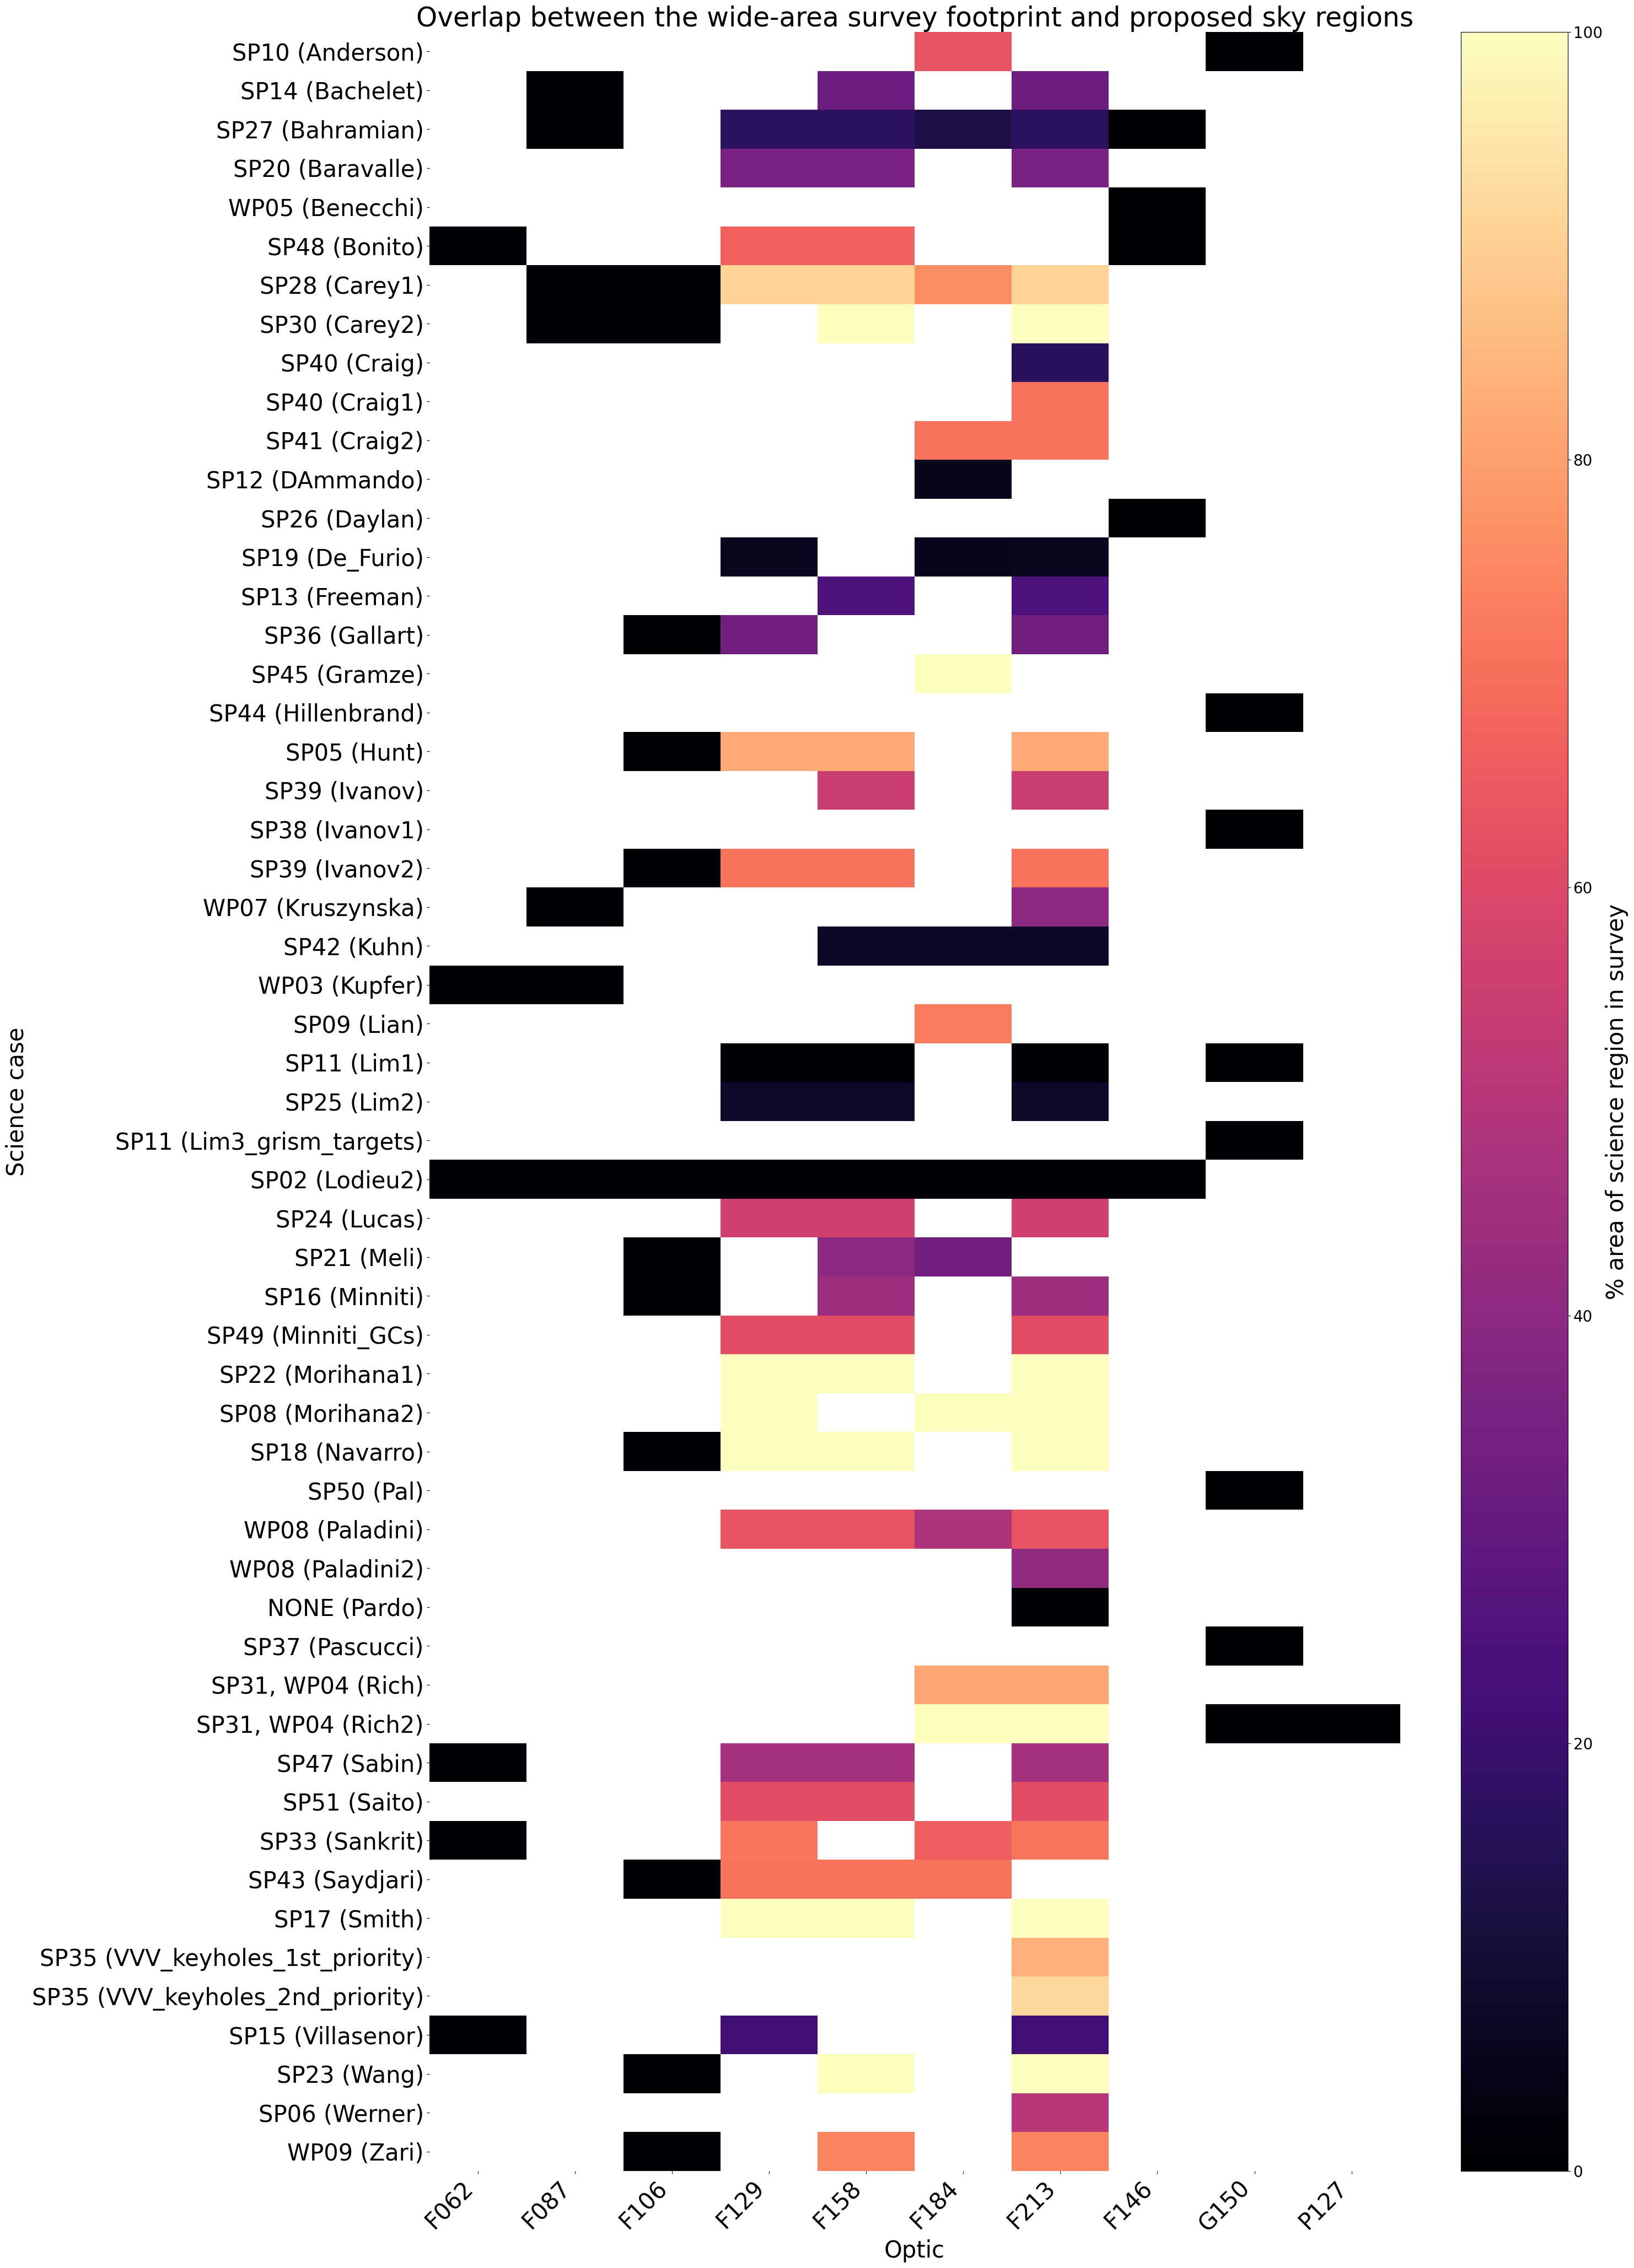

In [7]:
strategy_name = 'wide_area'
metric_name = 'M1_%pix'
metric_label = '% area of science region in survey'

plot_file = path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_all_science_cases.png')
title = 'Overlap between the wide-area survey footprint and proposed sky regions'
plot_metric_optic_heatmap(sim_config, science_cases, m1_results, strategy_name, 
                                  metric_name, metric_label, plot_file, title=title) 
    

## Deep/Spectroscopic and Time Domain Fields

Given the trade off between area observed in the wide-area survey and the number of filters used to do so, the RGPS opted to obtain observations in the bluer passbands and spectroscopic elements only for selected field in the deep/spectroscopic element of the strategy. 

Due to the time required for these multiband observations, the area covered could only be small, resulting in low percentage overlap with community-requested sky areas.  Nevertheless, it is instructive to examine which deep fields overlap even partially with which science cases. 

While this isn't a formal numerical metric, M1a_ddf_footprint provides information on which science cases include deep/spectro fields within their desired survey regions.

In [10]:
# Load M1a metric results
m1a_results_file = path.join(getcwd(), '..', 'metric_results', 'M1a_ddf_footprint_combined_results.txt')
m1a_results = Table.read(m1a_results_file, format='ascii')
m1a_results

Deep/spectro/TD field,Science_case,Science_code,Science_topics,Deep/spectro field,Science_cases,Science_codes
str22,str25,str10,str411,str21,str250,str145
Deep_NGC6357_Lobster,Saito,SP51,"Stellar populations,Galactic Center,Galactic structure,Stellar populations,Solar System Objects",--,--,--
Deep_Window_355.0-0.3,Saito,SP51,"Stellar populations,Galactic Center,Galactic structure,Stellar populations,Solar System Objects",--,--,--
Deep_VVV_CL001_UKS_1,Saito,SP51,"Stellar populations,Galactic Center,Galactic structure,Stellar populations,Solar System Objects",--,--,--
TDS_Galactic_Center_Q4,Saito,SP51,"Stellar populations,Galactic Center,Galactic structure,Stellar populations,Solar System Objects",--,--,--
TDS_Galactic_Center_Q1,Saito,SP51,"Stellar populations,Galactic Center,Galactic structure,Stellar populations,Solar System Objects",--,--,--
TDS_NGC6334_6357,Saito,SP51,"Stellar populations,Galactic Center,Galactic structure,Stellar populations,Solar System Objects",--,--,--
Deep_M17_Omega,Saydjari,SP43,ISM,--,--,--
Deep_NGC6357_Lobster,Minniti_GCs,SP49,GC,--,--,--
Deep_Window_355.0-0.3,Minniti_GCs,SP49,GC,--,--,--


In [12]:
# Group the information by deep field 
ddf_list = list(set([str(name) for name in m1a_results['Deep/spectro/TD field']]))
ddf_list.sort()

data = []
for ddf in ddf_list:
    rows = m1a_results['Deep/spectro/TD field'] == ddf
    topics = []
    for topic in m1a_results['Science_topics'][rows]: 
        entries = str(topic).split(',')
        for item in entries:
            topics.append(item)
    topics = list(set(topics))
    data.append(
        [
            ddf,
            ','.join(m1a_results['Science_case'][rows]),
            ','.join(m1a_results['Science_code'][rows]),
            ','.join(topics),
        ]
    )
data = np.array(data)

group_results = Table([
            Column(name='Deep/spectro/TD field', data=data[:,0], dtype='S30'),
            Column(name='Science_cases', data=data[:,1], dtype='S250'),
            Column(name='Science_codes', data=data[:,2], dtype='S250'),
            Column(name='Science_topics', data=data[:,3], dtype='S600'),
        ])

output_file = path.join(getcwd(), '..', 'metric_results', 'M1a_ddf_footprint_grouped_results.txt')
group_results.write(output_file, format='ascii', delimiter=' ', overwrite=True)
group_results

Deep/spectro/TD field,Science_cases,Science_codes,Science_topics
bytes30,bytes250,bytes250,bytes600
--,,,
Deep_ASSC_85,"Sankrit,Baravalle,Bahramian,Hillenbrand,Rich,Gallart,Kruszynska,Lucas,De_Furio,Meli,DAmmando,Carey1,Anderson,Bachelet,Ivanov,Hunt,Paladini,Werner,Sabin,Craig,Zari","SP33,SP20,SP27,SP44,SP31, WP04,SP36,WP07,SP24,SP19,SP21,SP12,SP28,SP10,SP14,SP39,SP05,WP08,SP06,SP47,SP40,WP09","SFR,Red Giant Stars,GC,Sgr A*,Cosmic rays,Stellar properties,Microlensing,Gal. mag. field,AGN,Symbiotic stars,Compact binaries,SNR,X-ray binaries,CV,OC,Novae,AGB,Star clusters,RR Lyrae,Galactic Center,Galaxies,Galactic structure,Planetary nebulae,Extinction map,Neptune Trojans,Stellar ages,YSO,Ionized gas,Survey overlap"
Deep_Acrux,"Sankrit,Baravalle,Bahramian,Hillenbrand,Rich,Kruszynska,Lucas,Meli,Carey1,Anderson,Bachelet,Ivanov,Hunt,Paladini,Werner,Sabin,Craig,Minniti,Zari","SP33,SP20,SP27,SP44,SP31, WP04,WP07,SP24,SP21,SP28,SP10,SP14,SP39,SP05,WP08,SP06,SP47,SP40,SP16,WP09","SFR,Red Giant Stars,GC,Sgr A*,Cosmic rays,Stellar properties,Microlensing,Gal. mag. field,AGN,Symbiotic stars,Compact binaries,SNR,X-ray binaries,CV,OC,Novae,AGB,Star clusters,RR Lyrae,Galactic Center,FFP,Galaxies,Galactic structure,Planetary nebulae,Extinction map,Neptune Trojans,YSO,Ionized gas,Survey overlap"
Deep_G333,"Sankrit,Villasenor,Baravalle,Bahramian,Rich,Gallart,Lucas,De_Furio,Meli,Carey1,Anderson,Bachelet,Ivanov,Hunt,Paladini,Werner,Sabin,Craig,Zari","SP33,SP15,SP20,SP27,SP31, WP04,SP36,SP24,SP19,SP21,SP28,SP10,SP14,SP39,SP05,WP08,SP06,SP47,SP40,WP09","SFR,Red Giant Stars,Sgr A*,Cosmic rays,Microlensing,Gal. mag. field,AGN,Symbiotic stars,SNR,X-ray binaries,Massive stars,OC,Novae,AGB,CV,Galactic Center,Galaxies,Planetary nebulae,Extinction map,Stellar ages,Survey overlap,YSO,Ionized gas,Star clusters"
Deep_M17_Omega,"Saydjari,Sankrit,Villasenor,Baravalle,Bahramian,Lim3_grism_targets,Rich,VVV_keyholes_2nd_priority,Gallart,Kruszynska,Lucas,Meli,Ivanov2,Carey1,Craig1,Anderson,Bachelet,Ivanov,Hunt,Craig2,Paladini,Werner,Sabin,Craig,Ivanov1,Zari","SP43,SP33,SP15,SP20,SP27,SP11,SP31, WP04,SP35,SP36,WP07,SP24,SP21,SP39,SP28,SP40,SP10,SP14,SP39,SP05,SP41,WP08,SP06,SP47,SP40,SP38,WP09","SFR,Keyholes,Red Giant Stars,GC,Sgr A*,Cosmic rays,ISM,Microlensing,Gal. mag. field,AGN,Symbiotic stars,Compact binaries,SNR,Stellar spectroscopy,Massive stars,X-ray binaries,CV,OC,Novae,AGB,Star clusters,RR Lyrae,Galactic Center,Galaxies,Galactic structure,Planetary nebulae,Extinction map,Neptune Trojans,Stellar ages,YSO,Ionized gas,Survey overlap"
Deep_NGC3324_Carina,"Villasenor,Baravalle,Bahramian,Rich,Kruszynska,Lian,Lucas,Meli,Anderson,Bachelet,Lim2,Bonito,Werner,Craig,Minniti,Zari","SP15,SP20,SP27,SP31, WP04,WP07,SP09,SP24,SP21,SP10,SP14,SP25,SP48,SP06,SP40,SP16,WP09","SFR,GC,Sgr A*,Cosmic rays,Microlensing,Gal. mag. field,AGN,Compact binaries,SNR,X-ray binaries,Massive stars,CV,OC,Molecular Clouds,Novae,RR Lyrae,Galactic Center,FFP,Galaxies,Galactic structure,Neptune Trojans,YSO,Ionized gas"
Deep_NGC5269_5281,"Sankrit,Baravalle,Bahramian,Rich,Kruszynska,Lucas,Meli,Carey1,Anderson,Bachelet,Ivanov,Hunt,Paladini,Werner,Sabin,Craig,Minniti,Zari","SP33,SP20,SP27,SP31, WP04,WP07,SP24,SP21,SP28,SP10,SP14,SP39,SP05,WP08,SP06,SP47,SP40,SP16,WP09","SFR,Red Giant Stars,GC,Sgr A*,Cosmic rays,Microlensing,Gal. mag. field,AGN,Symbiotic stars,Compact binaries,SNR,X-ray binaries,CV,OC,Novae,AGB,Star clusters,RR Lyrae,Galactic Center,FFP,Galaxies,Galactic structure,Planetary nebulae,Extinction map,Neptune Trojans,YSO,Ionized gas,Survey overlap"
Deep_NGC6357_Lobster,"Saito,Minniti_GCs,Sankrit,Villasenor,Baravalle,Bahramian,Gramze,Rich,Gallart,Kruszynska,Lucas,De_Furio,Meli,Carey1,Navarro,Anderson,Bachelet,Ivanov,Hunt,Paladini,Werner,Sabin,Craig,Zari","SP51,SP49,SP33,SP15,SP20,SP27,SP45,SP31, WP04,SP36,WP07,SP24,SP19,SP21,SP28,SP18,SP10,SP14,SP39,SP05,WP08,SP06,SP47,SP40,WP09","SFR,Red Giant Stars,GC,Sgr A*,Cosmic rays,Microlensing,Gal. mag. field,AGN,Symbiotic stars,Compact binaries,SNR,